In [1]:
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import keras

In [3]:
final_data=pd.read_csv('final_toxic.csv')
final_data=final_data.sample(frac=1)

In [4]:
final_data.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
71146,71146,be70bc1270ce5811,arrested protesting place time ban protesting ...,0,0,0,0,0,0
16346,16346,2b177c45fd01adb1,mergingreorganising other tv page please take ...,0,0,0,0,0,0
18165,18165,2fff5fb4791a343e,thinking it doughnut not fact make canary beco...,0,0,0,0,0,0
138689,138689,e610dcce30e70d38,wow drama queen dont grow a pair learn write p...,0,0,0,0,0,0
72097,72097,c101155d0d862543,rename eswikibooks done left note too regard,0,0,0,0,0,0


In [5]:
final_data.shape

(159571, 9)

In [6]:
final_data.dropna(inplace=True)
final_data.drop_duplicates(inplace=True)

In [7]:
final_data.shape

(159505, 9)

In [8]:
value=final_data.iloc[:,2:].sum(axis=1)

In [9]:
labels_count=value.value_counts()

In [10]:
labels_count=labels_count.iloc[1:]

# TF-IDF 

In [11]:
vectorizer=TfidfVectorizer(max_features=10000)
vectors=vectorizer.fit_transform(final_data['comment_text'])

In [12]:
X=vectors.toarray()

In [13]:
X_train,X_test,Y_train,Y_test=train_test_split(X,final_data.iloc[:,3:],test_size=0.3)

# Model Building

In [14]:
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.activations import relu,sigmoid
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
early_stopping = EarlyStopping()

In [16]:
model=Sequential()
model.add(Dense(units=128,activation=relu,kernel_regularizer=tensorflow.keras.regularizers.L2(l2=0.001),
            bias_regularizer=tensorflow.keras.regularizers.L2(l2=0.001)))
model.add(Dropout(0.4))
model.add(Dense(units=64,activation=relu,kernel_regularizer=tensorflow.keras.regularizers.L2(l2=0.001),
            bias_regularizer=tensorflow.keras.regularizers.L2(l2=0.001)))
model.add(Dropout(0.4))
model.add(Dense(units=32,activation=relu,kernel_regularizer=tensorflow.keras.regularizers.L2(l2=0.001),
            bias_regularizer=tensorflow.keras.regularizers.L2(l2=0.001)))
model.add(Dropout(0.4))
model.add(Dense(units=6,activation=sigmoid,kernel_regularizer=tensorflow.keras.regularizers.L2(l2=0.001),
            bias_regularizer=tensorflow.keras.regularizers.L2(l2=0.001)))

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001),loss=BinaryCrossentropy(),metrics=['binary_accuracy'])

In [18]:
es = EarlyStopping(monitor='val_loss',patience=3)

In [19]:
final_model=model.fit(X_train,Y_train,validation_data=[X_test,Y_test],epochs=10,callbacks=[es],shuffle=True)

Epoch 1/10
3490/3490 [==============================] - 111s 30ms/step - loss: 0.1556 - binary_accuracy: 0.9682 - val_loss: 0.1342 - val_binary_accuracy: 0.9751
Epoch 2/10
3490/3490 [==============================] - 89s 26ms/step - loss: 0.1412 - binary_accuracy: 0.9756 - val_loss: 0.1326 - val_binary_accuracy: 0.9771
Epoch 3/10
3490/3490 [==============================] - 82s 24ms/step - loss: 0.1407 - binary_accuracy: 0.9761 - val_loss: 0.1352 - val_binary_accuracy: 0.9743
Epoch 4/10
3490/3490 [==============================] - 82s 23ms/step - loss: 0.1405 - binary_accuracy: 0.9759 - val_loss: 0.1338 - val_binary_accuracy: 0.9753
Epoch 5/10
3490/3490 [==============================] - 73s 21ms/step - loss: 0.1400 - binary_accuracy: 0.9759 - val_loss: 0.1336 - val_binary_accuracy: 0.9770


In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280128   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1

In [21]:
from tensorflow.keras.utils import plot_model

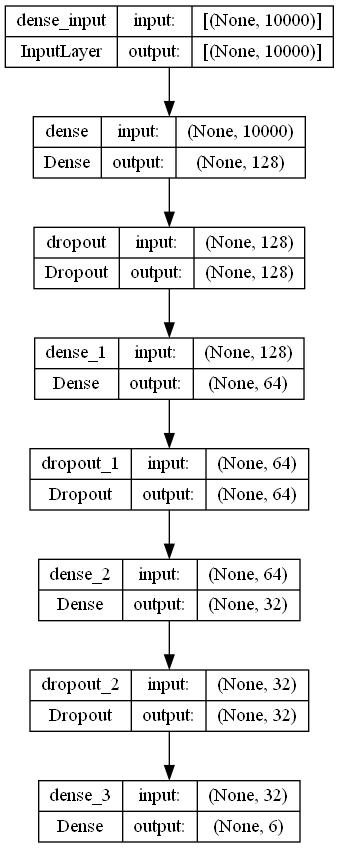

In [22]:
plot_model(model, to_file='graph.png', show_shapes=True)

In [23]:
model.evaluate(X_test,Y_test)

1496/1496 [==============================] - 6s 4ms/step - loss: 0.1336 - binary_accuracy: 0.9770


[0.13356778025627136, 0.9769700765609741]

In [24]:
y_predicted=model.predict(X_test)

1496/1496 [==============================] - 5s 3ms/step


# Model evaluation

In [25]:
for i in range(len(y_predicted)):
    for j in range(5):
        if y_predicted[i][j]>=0.2:
            y_predicted[i][j]=1
        else:
            y_predicted[i][j]=0

In [33]:
metric = tfa.metrics.F1Score(num_classes=6,average='weighted')
metric.update_state(np.array(Y_test),y_predicted)
result =(metric.result())

In [34]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=0.65559816>

In [29]:
print(f'The weighted f1 score is :{result}')

The weighted f1 score is :65.559814453125


In [32]:
p=vectorizer.transform([''])
p=p.toarray()

In [31]:
model.predict(p)

1/1 [==============================] - 0s 16ms/step


array([[0.16314468, 0.01878412, 0.0730066 , 0.01519888, 0.06512617,
        0.01899926]], dtype=float32)